# benchmarking Index with regard to cache locality and keeping track of duplicates
The current Index (Robin Hood hash table, linear probing, linear search, backshift deletion) is quite memory-efficient: It only stores the values, their positions, and another vector of probe positions required for Robin Hood hashing.
This means that when looking up a value, we do not have access to the hash values of the stored values and must compare based on values themselves. When probing this looks like this:

```julia
location = hash(elem) % ilength + 0x1
@inbounds for probeposition ∈ 0x1:(idx.longestprobe)
    pos = idx.indices[location]
    if pos > 0x0 && isequal(idx.vals[pos], elem)
        return location
    end
end
```
where `idx` is the Index object, `idx.vals` are the stored values, and `idx.indices` are the locations in `idx.vals` for the hash table buckets.
This is not very good for the CPU cache, as we are potentially jumping all over `idx.vals` during a search.
An alternative is to introduce a third vector of hash values with the same order as `idx.indices` and use that for comparison.
Only if the hash matches will the value be compared.
This sacrifices some memory, but may improve performance.

The following implementations will be compared:
- `Index`: The Index as currently implemented.
- `Index2`: Storing the output of `hash` directly. This is always `UInt` (usually `UInt64`), so takes up quite some memory.
- `Index3`: Storing `hash % size`. This may use a narrower type than `UInt`, but has the potential for more collisions.
- `Index4`: The same as `Index`, but additionally keeping track of how many duplicate entries there are in the index.
   This requires comparing the value to be inserted to the values of all passed buckets during search and is not very cache-friendly.
   Similarly, during deletion, the value to be deleted must be compared with the values of all backshifted buckets.
- `Index5`: A combination of `Index2` and `Index4`
- `Index6`: A combination of `Index3` and `Index4`

In [1]:
using Random
using Statistics
using Test
using BenchmarkTools
using TidierPlots
using CategoricalArrays
using DataFrames
using CSV
using ProgressMeter

TidierPlots_set("plot_show", false)

function minimum_unsigned_type_for_n(n::Number)
    local mintype::Type
    for type ∈ [UInt8, UInt16, UInt32, UInt64, UInt128]
        mval = typemax(type)
        if mval >= n
            mintype = type
            break
        end
    end
    return mintype
end

include("index.jl")
include("index2.jl")
include("index3.jl")
include("index4.jl")
include("index5.jl")
include("index6.jl")

## unit tests
we first test the implementations for basic functionality

In [2]:
Random.seed!(42)
size = rand(100:200)

types_totest = (Index, Index2, Index3, Index4, Index5, Index6)

function make_testvalues(size::Integer)
    testvalues = Vector{String}(undef, size)
    for i in 1:size
        length = rand(1:200)
        testvalues[i] = randstring(length)
    end
    return testvalues
end

testvalues = make_testvalues(size)
testvalues2 = make_testvalues(size)

@testset "type $(string(t))" for t in types_totest
    idx = t(testvalues)
    @testset "integer indexing" begin
        @testset "element: $i" for (i, v) in enumerate(testvalues)
            @test idx[i] == v
        end
    end

    @testset "value indexing" begin
        @testset "element: $i" for (i, v) in enumerate(testvalues)
            @test idx[v] == i
        end
    end


    testvalues3 = copy(testvalues)
    @testset "value replacement" begin
        @testset "element: $i" for (i, v) in enumerate(testvalues)
            testvalues3[i] = testvalues2[i]
            idx[v] = testvalues2[i]
            @test idx == testvalues3
        end
    end

    @testset "index replacement" begin
        @testset "element $i" for (i, v) in enumerate(testvalues2)
            testvalues3[i] = testvalues[i]
            idx[i] = testvalues[i]
            @test idx == testvalues3
        end
    end
end;

Test Summary: | Pass  Total  Time
type Index    |  652    652  2.9s
Test Summary: | Pass  Total  Time
type Index2   |  652    652  2.0s
Test Summary: | Pass  Total  Time
type Index3   |  652    652  1.3s
Test Summary: | Pass  Total  Time
type Index4   |  652    652  1.3s
Test Summary: | Pass  Total  Time
type Index5   |  652    652  0.9s
Test Summary: | Pass  Total  Time
type Index6   |  652    652  1.1s


## benchmarks
The rough benchmarking scheme is taken from [Emmanuel Gossaert](https://codecapsule.com/2013/11/11/robin-hood-hashing/). We first construct an ordered set with 100000 strings. We then replace 10000 elements with random newly generated strings. This procedure is repeated 50 times, after each iteration we measure different statistics regarding probe length, time required to perform the replacement operation, and also time to simply access elements without replacing them.

In [3]:
Random.seed!(42)
size = 100000

function ripple(idx, range::AbstractUnitRange, insert_duplicates=false)
    for i in range
        length = rand(200:500)
        idx[i] = randstring(length)
    end
    if insert_duplicates
        nduplicates = round(Int, 0.05 * length(range))
        dupidx = range[randperm(length(range))[begin:nduplicates]] # sample w/o replacement
        replacementidx = rand(1:length(idx), nduplicates)
        for (ii, ri) in zip(dupidx, replacementidx)
            idx[ii] = idx[ri]
        end
    end
end

function access(idx, range::AbstractUnitRange)
    for (j, i) in enumerate(range)
        r = idx[i]
        Base.donotdelete(r)
    end
end

# compile the functions
for t in types_totest
    idx = t(string.(collect(1:size)))
    ripple(idx, 1:2)
    access(idx, 1:2)
end

testvalues = make_testvalues(size)
results = DataFrame(
    iter=UInt[],
    time=Float64[],
    bytes_alloc=UInt[],
    malloc_realloc_calls=UInt[],
    time_access=Float64[],
    type=CategoricalVector(undef, 0),
    duplicates=Bool[]
);

In [4]:
nripple = Int(round(0.1 * size))
niters = 50

pbar = Progress(length(types_totest) * niters * 2)
for insert_duplicates in (false, true)
    for t in types_totest
        Random.seed!(42)
        idx = t(testvalues)
        for (i, start) in enumerate(Int.(round.(range(1, size - nripple + 1, length=niters))))
            next!(pbar; showvalues=((:index, string(t)), (:start, start), (:duplicates, insert_duplicates)))
            stats = @timed ripple(idx, start:(start + nripple - 1), insert_duplicates)
            stats_access = @benchmark access($idx, $start:($start + $nripple - 1)) seconds=0.5
                    
            probepositions = filter(x -> x > 0x0, idx.probepositions)
            push!(
                results,
                Dict(
                    :iter => i,
                    :time => stats.time,
                    :bytes_alloc => stats.gcstats.allocd,
                    :malloc_realloc_calls => stats.gcstats.malloc + stats.gcstats.realloc,
                    :time_access => mean(stats_access.times) / 1e9,
                    :type => string(t),
                    :duplicates => insert_duplicates,
                ),
            )
        end
    end
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/N660J/src/ProgressMeter.jl:607
Progress: 100%|█████████████████████████████████████████| Time: 0:40:41
        index: Index6
        start: 90001
   duplicates: true


## benchmarking results

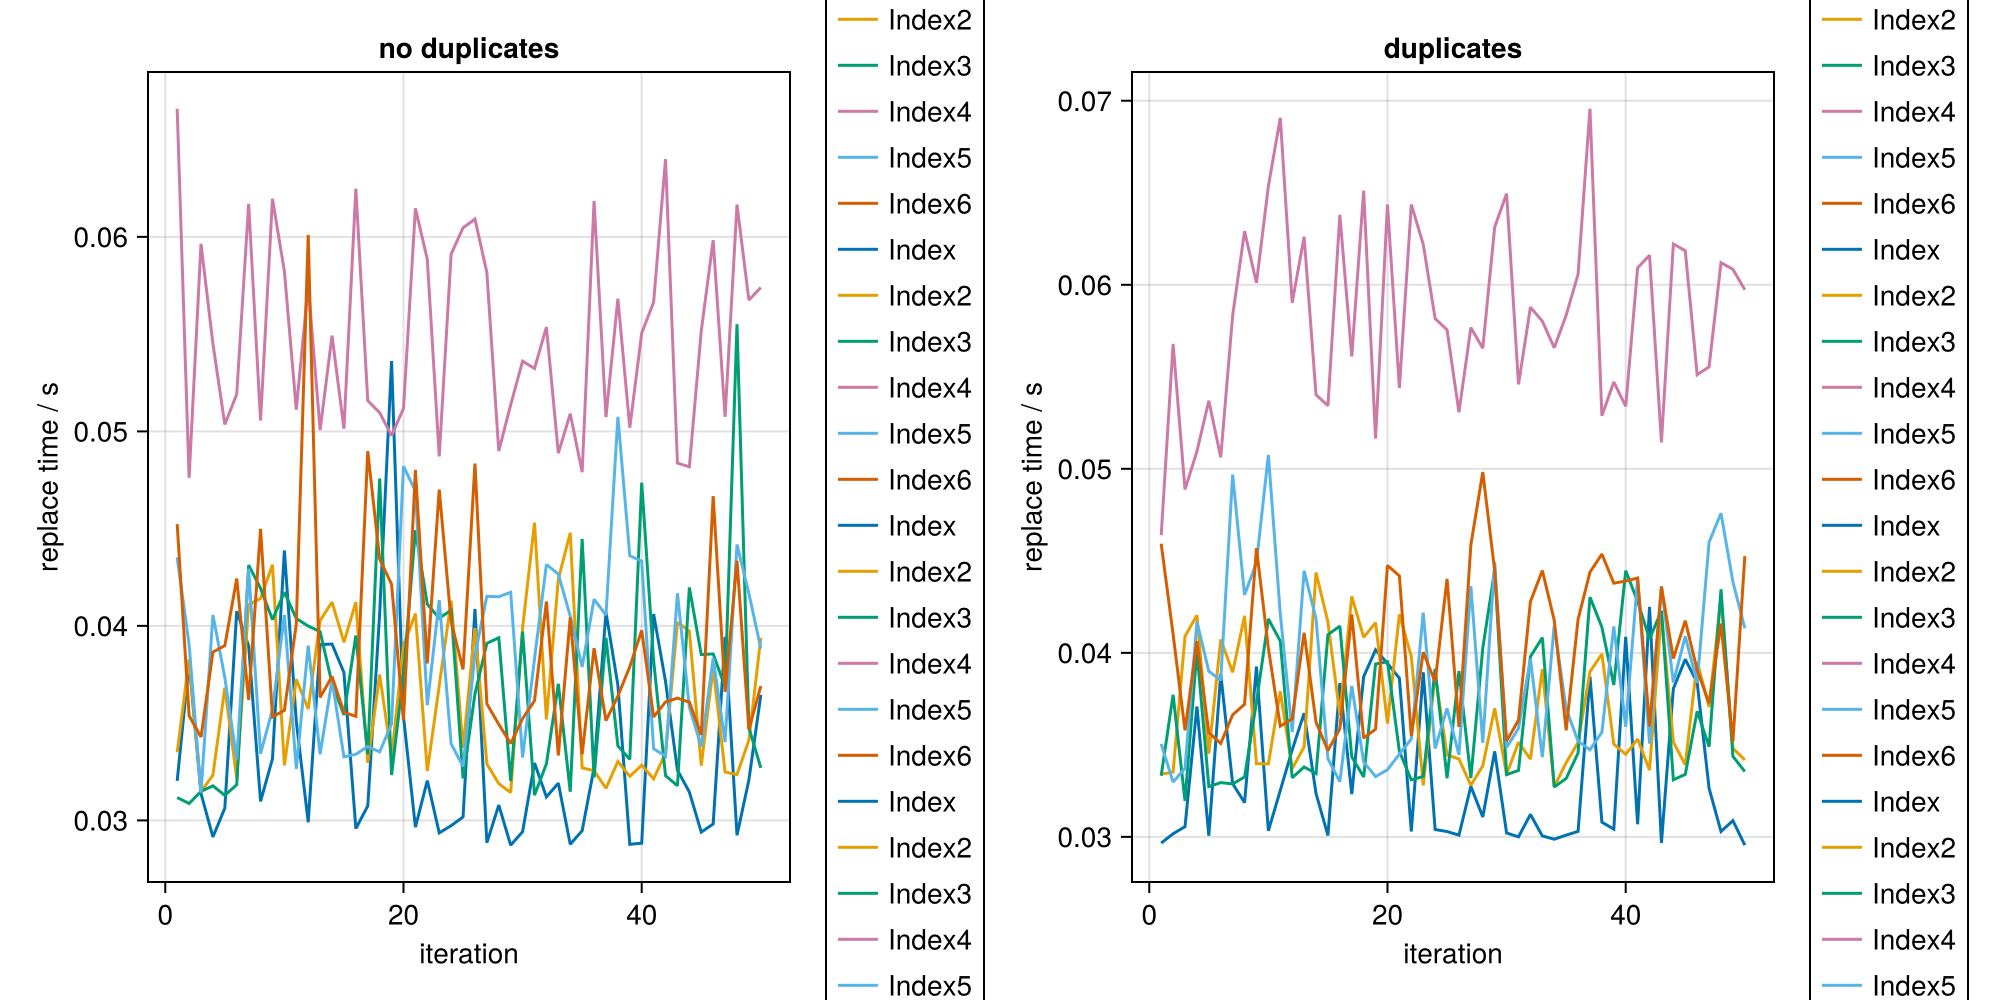

In [5]:
draw_ggplot((ggplot(results[results.duplicates .== false, :], aes(x=:iter, y=:time, color=:type)) +
    geom_line() +
    labs(title="no duplicates", x="iteration", y="replace time / s") +
    guides(color="legend")) +
(ggplot(results[results.duplicates .== true, :], aes(x=:iter, y=:time, color=:type)) +
    geom_line() +
    labs(title="duplicates", x="iteration", y="replace time / s") +
    guides(color="legend")), (1000, 500))

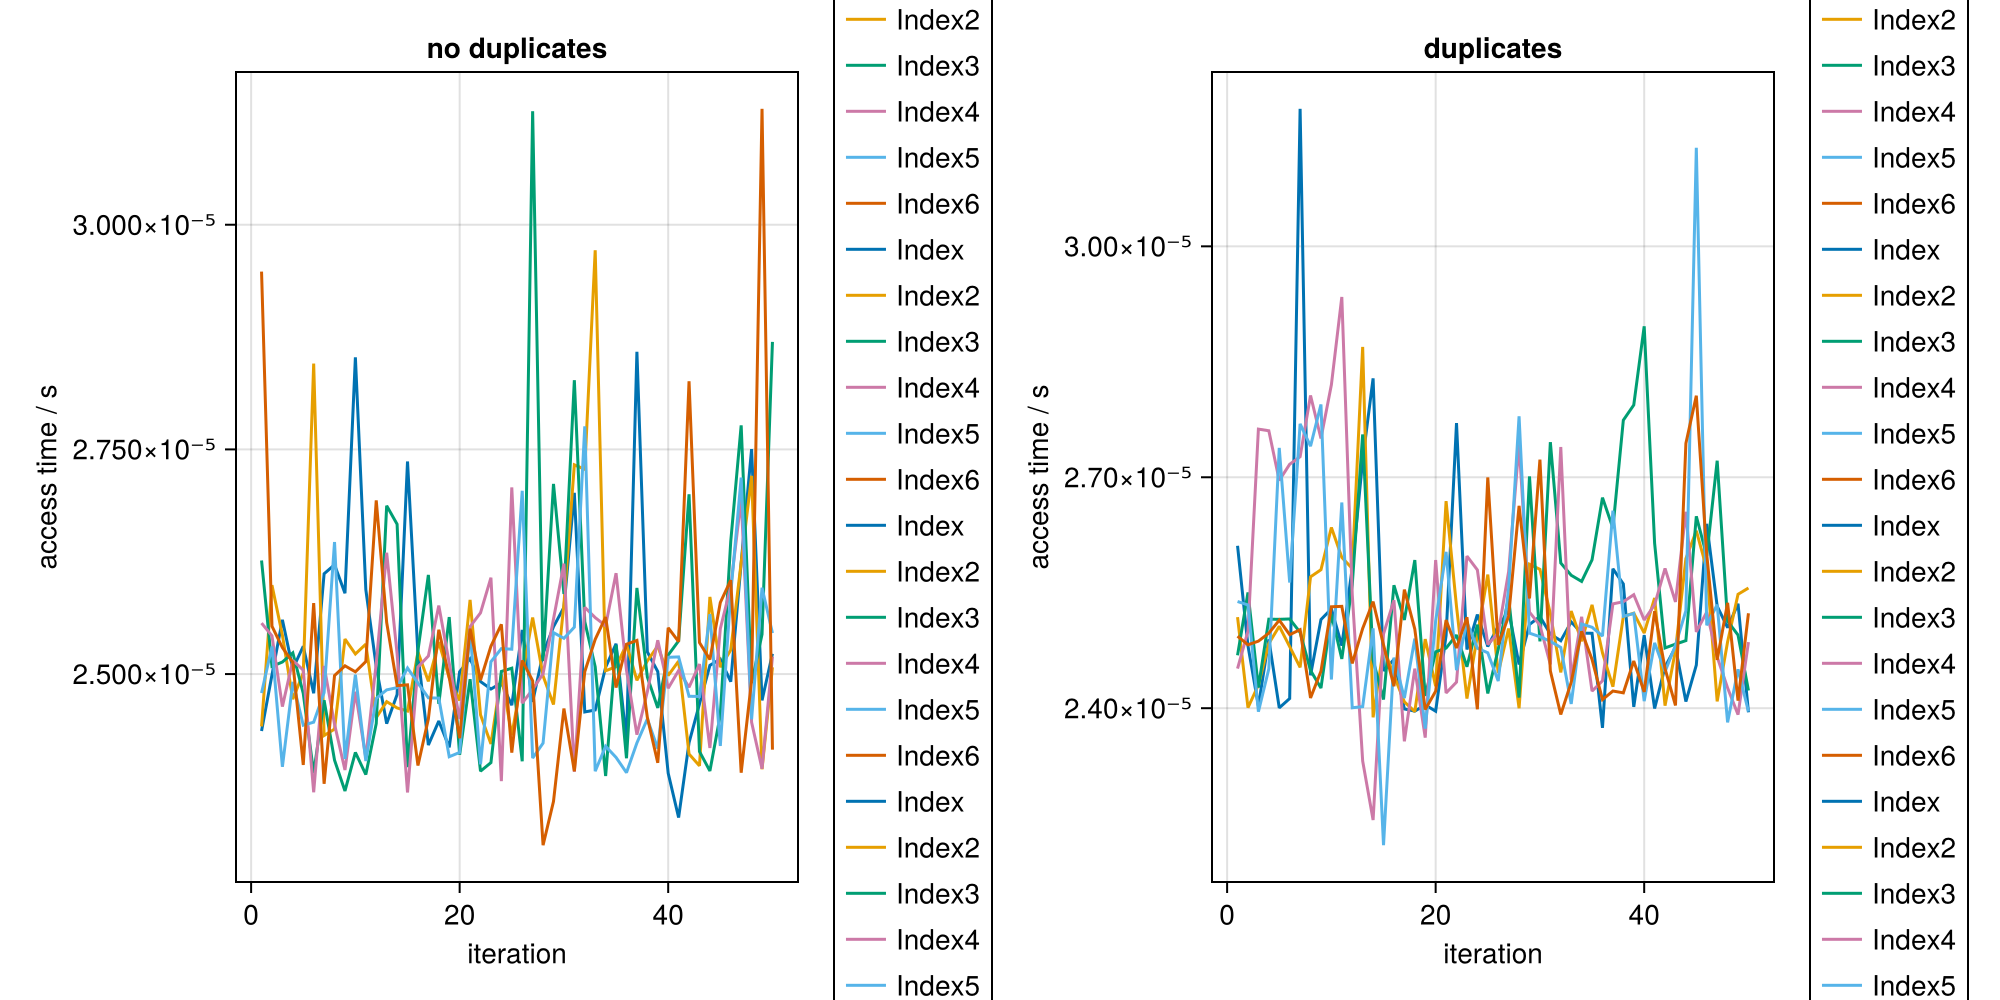

In [6]:
draw_ggplot((ggplot(results[results.duplicates .== false, :], aes(x=:iter, y=:time_access, color=:type)) +
    geom_line() +
    labs(title="no duplicates", x="iteration", y="access time / s") +
    guides(color="legend")) +
(ggplot(results[results.duplicates .== true, :], aes(x=:iter, y=:time_access, color=:type)) +
    geom_line() +
    labs(title="duplicates", x="iteration", y="access time / s") +
    guides(color="legend")), (1000, 500))

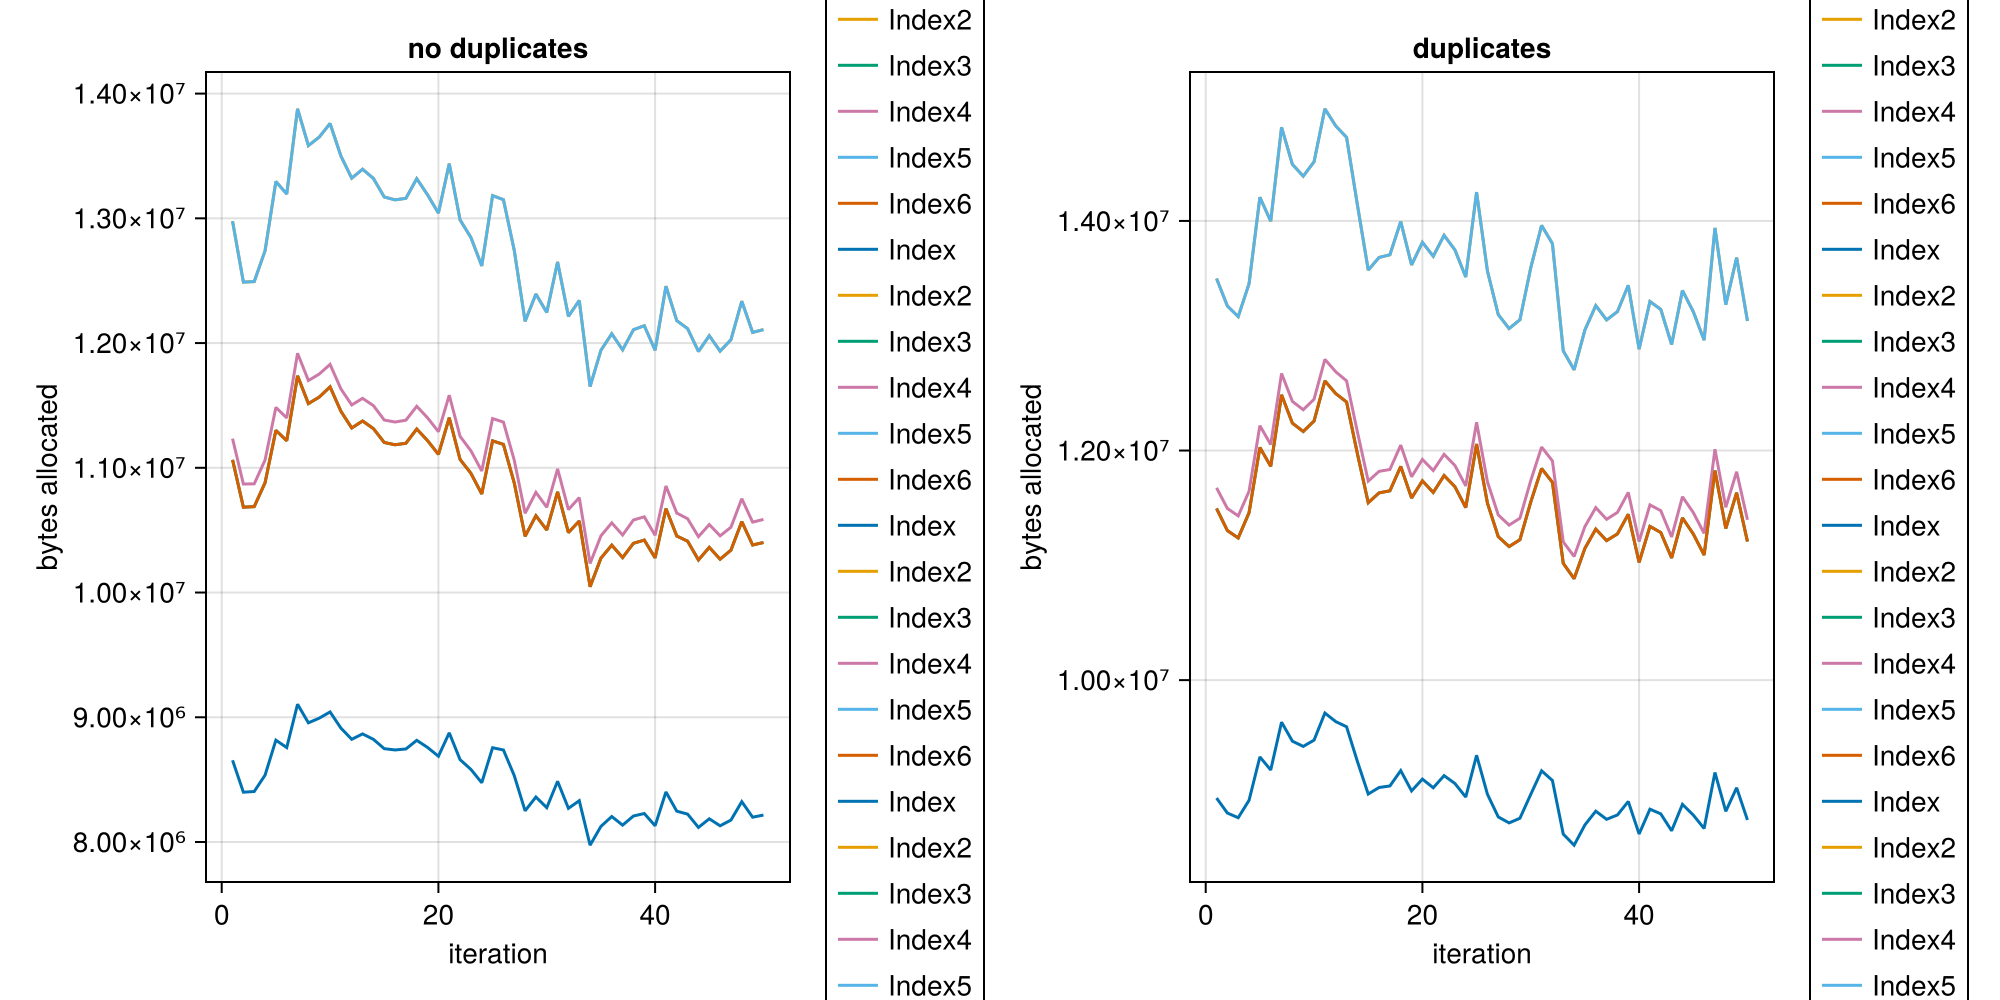

In [7]:
draw_ggplot((ggplot(results[results.duplicates .== false, :], aes(x=:iter, y=:bytes_alloc, color=:type)) +
    geom_line() +
    labs(title="no duplicates", x="iteration", y="bytes allocated") +
    guides(color="legend")) +
(ggplot(results[results.duplicates .== true, :], aes(x=:iter, y=:bytes_alloc, color=:type)) +
    geom_line() +
    labs(title="duplicates", x="iteration", y="bytes allocated") +
    guides(color="legend")), (1000, 500))

In [8]:
CSV.write("results.csv", results)

"results.csv"

## conclusion
Cache locality does not seem important here. To the contrary, Index2 and Index3 have slightly higher replace times than Index. However, keeping hashes around does help with keeping track of duplicates: Index5 and Index6 do not have higher replace times than Index2/3, while Index4 takes about twice as long to replace items than Index/Index2/Index3. Access times are not affected by any strategy. Since the expected workload in Muon has mostly read accesses and only rarely replacement of items, using Index4 is probably best, as we save memory due to not storing the vector of hashes. To be reevaluated if users complain.

In [9]:
versioninfo()

Julia Version 1.11.6
Commit 9615af0f269 (2025-07-09 12:58 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 24 × Intel(R) Xeon(R) CPU E5-2620 v3 @ 2.40GHz
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 (ORCJIT, haswell)
Threads: 1 default, 0 interactive, 1 GC (on 24 virtual cores)
